# Quaternion Testing

The goal of this testing is to test rotations with quaternions vs traditional matrix rotations.
I'm hoping to see that one is more numerically stable than the other when used for particle spin tracking.


In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import numba
import sympy

In [3]:
np.convolve([1, 0, 1],[1, -1])

array([ 1, -1,  1, -1])

In [2]:
@numba.jit
def bruteRotationStandard(initVec, matrix, numIter):
	outVec = initVec[:]
	for i in range(numIter):
		outVec = np.dot(matrix, outVec)
	return outVec

@numba.jit
def bruteRotationStandardCombo(initVec, matrix, numIter, numPer):
	outVec = initVec[:]
	for i in range(int(numIter/numPer)):
		tempMat = matrix
		for j in range(numPer):
			tempMat = np.dot(matrix, tempMat)
		outVec = np.dot(tempMat, outVec)
	return outVec

#@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

#@numba.jit
def norm(a):
	return a/vecLen(a)

def angleBetween(a, b):
	normA = norm(a)
	normB = norm(b)
	return np.dot(normA, normB)/(vecLen(normA)*vecLen(normB))


@numba.jit
def qMult(q1, q2):
	w1, x1, y1, z1 = q1
	w2, x2, y2, z2 = q2
	w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
	x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
	y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
	z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
	return np.array([w, x, y, z], dtype=q1.dtype)

@numba.jit
def qMultFast(q1, q2):
	a, b, c, d = q1
	e, f, g, h = q2
	A1 = (d+b)*(f+g)
	A3 = (a-c)*(e+h)
	A4 = (a+c)*(e-h)
	A2 = A1 + A3 + A4
	A5 = 0.5*(A2 + (d-b)*(f-g))
	
	Q1 = A5-A1+(d-c)*(g-h)
	Q2 = A5-A2+(b+a)*(f+e)
	Q3 = A5-A3+(a-b)*(g+h)
	Q4 = A5-A4+(d+c)*(e-f)
	return np.array([Q1, Q2, Q3, Q4], dtype=q1.dtype)

@numba.jit
def qConjugate(q):
	w, x, y, z = q
	return np.array([w, -x, -y, -z], dtype=q.dtype)

@numba.jit
def qv_mult(q1, v1):
	q2 = np.array([0.0, *v1], dtype=q1.dtype)
	return qMult(qMult(q1, q2), qConjugate(q1))[1:]

@numba.jit
def norm(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def invert(a):
	return conjugate(a)/norm(a)


@numba.jit
def eulerToQuaternion(phi, theta, psi):
	qw = np.cos(phi/2) * np.cos(theta/2) * np.cos(psi/2) + np.sin(phi/2) * np.sin(theta/2) * np.sin(psi/2)
	qx = np.sin(phi/2) * np.cos(theta/2) * np.cos(psi/2) - np.cos(phi/2) * np.sin(theta/2) * np.sin(psi/2)
	qy = np.cos(phi/2) * np.sin(theta/2) * np.cos(psi/2) + np.sin(phi/2) * np.cos(theta/2) * np.sin(psi/2)
	qz = np.cos(phi/2) * np.cos(theta/2) * np.sin(psi/2) - np.sin(phi/2) * np.sin(theta/2) * np.cos(psi/2)
	return [qw, qx, qy, qz]

@numba.jit
def quaternionToEuler(w, x, y, z):
	t0 = 2 * (w * x + y * z)
	t1 = 1 - 2 * (x * x + y * y)
	X = np.atan2(t0, t1)
	t2 = 2 * (w * y - z * x)
	t2 = 1 if t2 > 1 else t2
	t2 = -1 if t2 < -1 else t2
	Y = np.asin(t2)
	t3 = 2 * (w * z + x * y)
	t4 = 1 - 2 * (y * y + z * z)
	Z = np.atan2(t3, t4)
	return X, Y, Z

@numba.jit
def cross(x, y):
	return np.array( (x[1]*y[2] - x[2]*y[1], x[2]*y[0] - x[0]*y[2], x[0]*y[1] - x[1]*y[0]))

@numba.jit
def fast_rot(q, v):
	t = 2*cross(q[1:], v)
	return v + q[0]*t + cross(q[1:], t)

@numba.jit
def bruteRotationQuaternionSlow(initVec, q, numIter):
	outVec = initVec[:]
	for i in range(numIter):
		outVec = qv_mult(q, outVec)
	return outVec

@numba.jit
def bruteRotationQuaternionFast(initVec, q, numIter):
	outVec = initVec[:]
	for i in range(numIter):
		outVec = fast_rot(q, outVec)
	return outVec

@numba.jit
def bruteRotationQuaternionFastCombo(initVec, q, numIter, perIter):
	numStep = numIter / perIter
	outVec = initVec[:]
	for i in range(numStep):
		tempq = q
		for j in range(perIter):
			tempq = qMult(q, tempq)
		outVec = fast_rot(tempq, outVec)
	return outVec

@numba.jit
def eulerRotationMatrix(alpha, beta, gamma):
	RotationMatrixUpperRow = [np.cos(beta)*np.cos(gamma), 
						  np.sin(alpha)*np.sin(beta)*np.cos(gamma) - np.cos(alpha)*np.sin(gamma), 
						  np.cos(alpha)*np.sin(beta)*np.cos(gamma) + np.sin(alpha)*np.sin(gamma)]
	RotationMatrixMiddleRow = [np.cos(beta)*np.sin(gamma), 
						  np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma), 
						  np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)]
	RotationMatrixLowerRow = [-np.sin(beta), np.sin(alpha)*np.cos(beta), np.cos(alpha)*np.cos(beta)]
	RotationMatrix = np.array([RotationMatrixUpperRow, RotationMatrixMiddleRow, RotationMatrixLowerRow], np.dtype(precision))
	return RotationMatrix

## Basic Test
First learn to do rotations with quaternions

In [3]:
precision = np.float64
vectorType = precision

init = [np.sqrt(3)/3.0, np.sqrt(3)/3.0, np.sqrt(3)/3.0]
initialVector = np.array(init, dtype=vectorType)

stepsPerFullRot = 1000
alpha = 2.0*np.pi/(stepsPerFullRot) #around x axis
beta =  0 #2.0*np.pi/(stepsPerFullRot/np.sqrt(2)*2) #around y axis
gamma = 0 #around z axis

eulerRotation = eulerRotationMatrix(alpha, beta, gamma).astype(precision)
q = np.array(eulerToQuaternion(alpha, beta, gamma), dtype=precision)

In [4]:
numIter = 1000000
comboNum = 10
finalPosNorm = bruteRotationStandard(initialVector, eulerRotation, numIter)
finalPosNormCombo = bruteRotationStandardCombo(initialVector, eulerRotation, numIter, comboNum)
finalPosQuatFast = bruteRotationQuaternionFast(initialVector, q, numIter)
finalPosQuatFastCombo = bruteRotationQuaternionFastCombo(initialVector, q, numIter, comboNum)

In [5]:
print('init', vecLen(initialVector))
print('standard matrix', vecLen(finalPosNorm), vecLen(initialVector) - vecLen(finalPosNorm))
print('matrix combo', vecLen(finalPosNormCombo), vecLen(initialVector) - vecLen(finalPosNormCombo))
print('standard quat', vecLen(finalPosQuatFast), vecLen(initialVector) - vecLen(finalPosQuatFast))
print('quat combo', vecLen(finalPosQuatFastCombo), vecLen(initialVector) - vecLen(finalPosQuatFastCombo))

init 1.0
standard matrix 0.9999999999908359 9.16411391216343e-12
matrix combo 0.9999999999974121 2.58792987040124e-12
standard quat 0.9999999999999934 6.5503158452884236e-15
quat combo 1.0000000000001383 -1.383337888682945e-13


In [6]:
print(np.sqrt(np.sum(np.square(np.subtract(initialVector, finalPosNorm)))))
print(np.sqrt(np.sum(np.square(np.subtract(initialVector, finalPosNormCombo)))))
print(np.sqrt(np.sum(np.square(np.subtract(initialVector, finalPosQuatFast)))))
print(np.sqrt(np.sum(np.square(np.subtract(initialVector, finalPosQuatFastCombo)))))

1.1223962089172284e-11
3.1703097308531113e-12
7.947987303456223e-15
5.236335533191956e-12


In [7]:
print(angleBetween(initialVector.astype(np.float64), finalPosNorm.astype(np.float64)))
print(angleBetween(initialVector.astype(np.float64), finalPosNormCombo.astype(np.float64)))
print(angleBetween(initialVector.astype(np.float64), finalPosQuatFast.astype(np.float64)))
print(angleBetween(initialVector.astype(np.float64), finalPosQuatFastCombo.astype(np.float64)))

1.0
1.0
1.0
1.0


In [8]:
%timeit bruteRotationStandard(initialVector, eulerRotation, numIter)

184 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit bruteRotationStandardCombo(initialVector, eulerRotation, numIter, comboNum)

409 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit bruteRotationQuaternionFast(initialVector, q, numIter)

288 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit bruteRotationQuaternionFastCombo(initialVector, q, numIter, comboNum)

105 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Visualizing the performance degredation

In [15]:
@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def bruteRotationQuaternionFast(initVec, q, numIter):
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(numIter):
		outVec = fast_rot(q, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

@numba.jit
def bruteRotationQuaternionFastCombo(initVec, q, numIter, perIter):
	numStep = numIter / perIter
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(int(numStep)):
		tempq = q
		for j in range(int(perIter)):
			tempq = qMult(q, tempq)
		outVec = fast_rot(tempq, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

@numba.jit
def bruteRotationStandard(initVec, matrix, numIter):
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(numIter):
		outVec = np.dot(matrix, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

@numba.jit
def bruteRotationStandardCombo(initVec, matrix, numIter, numPer):
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(int(numIter/numPer)):
		tempMat = matrix
		for j in range(numPer):
			tempMat = np.dot(matrix, tempMat)
		outVec = np.dot(tempMat, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

In [16]:
precision = np.float32
vectorType = precision

init = [np.sqrt(3)/3.0, np.sqrt(3)/3.0, np.sqrt(3)/3.0]
initialVector = np.array(init, dtype=vectorType)

stepsPerFullRot = 1000
alpha = 2.0*np.pi/(stepsPerFullRot) #around x axis
beta =  0 #2.0*np.pi/(stepsPerFullRot/np.sqrt(2)*2) #around y axis
gamma = 0 #around z axis

eulerRotation = eulerRotationMatrix(alpha, beta, gamma).astype(precision)
q = np.array(eulerToQuaternion(alpha, beta, gamma), dtype=precision)

In [17]:
numIter = int(1.0E7)
stepSize = int(10)
normalizationResultsTradMatrix = bruteRotationStandard(initialVector, eulerRotation, numIter)
normalizationResultsComboMatrix = bruteRotationStandardCombo(initialVector, eulerRotation, numIter, stepSize)
normalizationResultsTradQuat = bruteRotationQuaternionFast(initialVector, q, numIter)
normalizationResultsComboQuat = bruteRotationQuaternionFastCombo(initialVector, q, numIter, stepSize)

<Figure size 432x288 with 0 Axes>

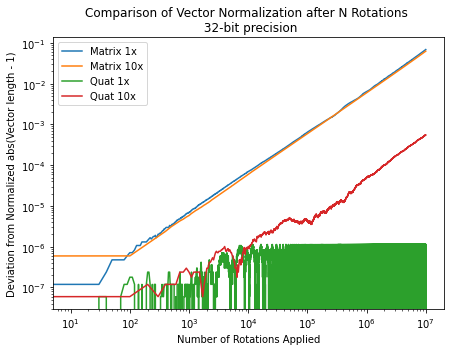

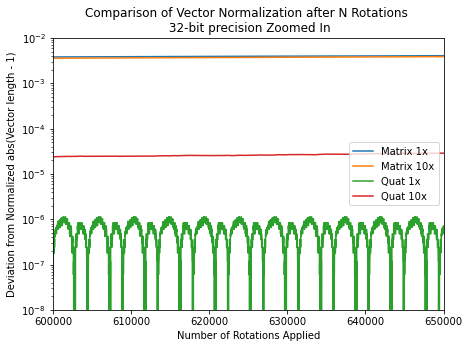

In [21]:
binsNorm = np.arange(0, numIter+1)
binsCombo = np.arange(0, numIter+1, stepSize)

plt.clf()
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradMatrix[1])-1.0)[::10], label='Matrix 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboMatrix[1])-1.0)[::10], label='Matrix 10x')
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradQuat[1])-1.0)[::10], label='Quat 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboQuat[1])-1.0)[::10], label='Quat 10x')
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
#ax.set_ylim(1E-8, 1E-2)
ax.set_xlabel('Number of Rotations Applied')
ax.set_ylabel('Deviation from Normalized abs(Vector length - 1)')
plt.title('Comparison of Vector Normalization after N Rotations \n 32-bit precision')
plt.show()

fig, ax = plt.subplots(1, figsize=(7, 5))
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradMatrix[1])-1.0)[::10], label='Matrix 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboMatrix[1])-1.0)[::10], label='Matrix 10x')
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradQuat[1])-1.0)[::10], label='Quat 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboQuat[1])-1.0)[::10], label='Quat 10x')
ax.legend()
ax.set_yscale("log")
ax.set_ylim(1E-8, 1E-2)
ax.set_xlabel('Number of Rotations Applied')
ax.set_ylabel('Deviation from Normalized abs(Vector length - 1)')
ax.set_xlim(0.6E6, 0.65E6)
plt.title('Comparison of Vector Normalization after N Rotations \n 32-bit precision Zoomed In')
plt.show()

In [24]:
precision = np.float64
vectorType = precision

init = [np.sqrt(3)/3.0, np.sqrt(3)/3.0, np.sqrt(3)/3.0]
initialVector = np.array(init, dtype=vectorType)

stepsPerFullRot = 1000
alpha = 2.0*np.pi/(stepsPerFullRot) #around x axis
beta =  0 #2.0*np.pi/(stepsPerFullRot/np.sqrt(2)*2) #around y axis
gamma = 0 #around z axis

eulerRotation = eulerRotationMatrix(alpha, beta, gamma).astype(precision)
q = np.array(eulerToQuaternion(alpha, beta, gamma), dtype=precision)

In [27]:
numIter = int(1.0E7)
stepSize = 10
normalizationResultsTradMatrix = bruteRotationStandard(initialVector, eulerRotation, numIter)
normalizationResultsComboMatrix = bruteRotationStandardCombo(initialVector, eulerRotation, numIter, stepSize)
normalizationResultsTradQuat = bruteRotationQuaternionFast(initialVector, q, numIter)
normalizationResultsComboQuat = bruteRotationQuaternionFastCombo(initialVector, q, numIter, stepSize)

<Figure size 432x288 with 0 Axes>

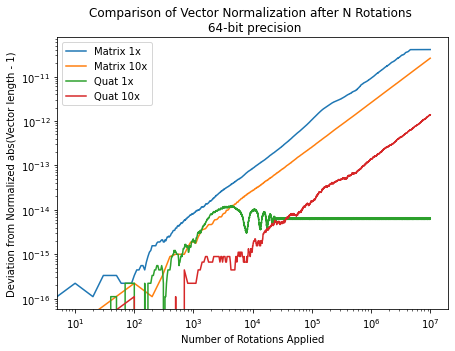

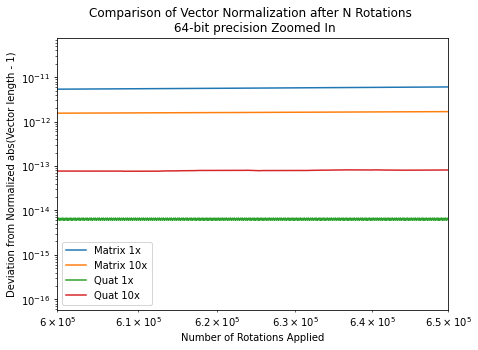

In [28]:
binsNorm = np.arange(0, numIter+1)
binsCombo = np.arange(0, numIter+1, stepSize)

plt.clf()
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradMatrix[1])-1.0)[::10], label='Matrix 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboMatrix[1])-1.0)[::10], label='Matrix 10x')
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradQuat[1])-1.0)[::10], label='Quat 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboQuat[1])-1.0)[::10], label='Quat 10x')
ax.legend()
ax.set_yscale("log")
#ax.set_ylim(1E-8, 1E-2)
ax.set_xscale('log')
ax.set_xlabel('Number of Rotations Applied')
ax.set_ylabel('Deviation from Normalized abs(Vector length - 1)')
plt.title('Comparison of Vector Normalization after N Rotations \n 64-bit precision')
plt.show()

fig, ax = plt.subplots(1, figsize=(7, 5))
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradMatrix[1])-1.0)[::10], label='Matrix 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboMatrix[1])-1.0)[::10], label='Matrix 10x')
ax.plot(binsNorm[::10], np.abs(np.array(normalizationResultsTradQuat[1])-1.0)[::10], label='Quat 1x')
ax.plot(binsCombo[::10], np.abs(np.array(normalizationResultsComboQuat[1])-1.0)[::10], label='Quat 10x')
ax.legend()
ax.set_yscale("log")
ax.set_xscale('log')
ax.set_xlabel('Number of Rotations Applied')
ax.set_ylabel('Deviation from Normalized abs(Vector length - 1)')
ax.set_xlim(0.6E6, 0.65E6)
plt.title('Comparison of Vector Normalization after N Rotations \n 64-bit precision Zoomed In')
plt.show()

## Exploring Renormalization Errors

In [72]:
@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def renorm(a):
	return a/vecLen(a)

@numba.jit
def quatRotNorm(initVec, q, numIter, renormInt):
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(numIter):
		if not i % renormInt:
			outVec = renorm(outVec)
		outVec = fast_rot(q, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

@numba.jit
def quatRotNormCombo(initVec, q, numIter, perIter, renormInt):
	numStep = numIter / perIter
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(int(numStep)):
		tempq = q
		for j in range(int(perIter)):
			tempq = qMult(q, tempq)
		if not i % renormInt:
			outVec = renorm(outVec)
		outVec = fast_rot(tempq, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

@numba.jit
def stanRotNorm(initVec, matrix, numIter, renormInt):
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(numIter):
		if not i % renormInt:
			outVec = renorm(outVec)
		outVec = np.dot(matrix, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

@numba.jit
def stanRotNormCombo(initVec, matrix, numIter, numPer, renormInt):
	outVec = initVec[:]
	lengths = [vecLen(outVec)]
	for i in range(int(numIter/numPer)):
		tempMat = matrix
		for j in range(numPer):
			tempMat = np.dot(matrix, tempMat)
		if not i % renormInt:
			outVec = renorm(outVec)
		outVec = np.dot(tempMat, outVec)
		lengths.append(vecLen(outVec))
	return outVec, lengths

In [78]:
precision = np.float64
vectorType = precision

init = [np.sqrt(3)/3.0, np.sqrt(3)/3.0, np.sqrt(3)/3.0]
initialVector = np.array(init, dtype=vectorType)

stepsPerFullRot = 1000
alpha = 2.0*np.pi/(stepsPerFullRot) #around x axis
beta =  0 #2.0*np.pi/(stepsPerFullRot/np.sqrt(2)*2) #around y axis
gamma = 0 #around z axis

eulerRotation = eulerRotationMatrix(alpha, beta, gamma).astype(precision)
q = np.array(eulerToQuaternion(alpha, beta, gamma), dtype=precision)

numIter = 1E6
numPer = 10
numRenorms = np.unique(np.logspace(0, 6, 100).astype(int))

resTrads = []
resTradCombos = []
resQuats = []
resQuatCombos = []

for numRenorm in numRenorms:
	resTrad = stanRotNorm(initialVector, eulerRotation, numIter, numRenorm)[0]
	resTradCombo = stanRotNormCombo(initialVector, eulerRotation, numIter, stepSize, numRenorm)[0]
	resQuat = quatRotNorm(initialVector, q, numIter, numRenorm)[0]
	resQuatCombo = quatRotNormCombo(initialVector, q, numIter, stepSize, numRenorm)[0]
	
	resTrads.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resTrad)))))
	resTradCombos.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resTradCombo)))))
	resQuats.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resQuat)))))
	resQuatCombos.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resQuatCombo)))))

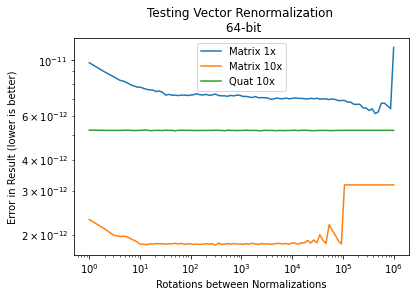

In [80]:
xvals = numRenorms
plt.plot(xvals, resTrads, label='Matrix 1x')
plt.plot(xvals, resTradCombos, label='Matrix 10x')
#plt.plot(xvals, resQuats, label='Quat 1x')
plt.plot(xvals, resQuatCombos, label='Quat 10x')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Rotations between Normalizations')
plt.ylabel('Error in Result (lower is better)')
plt.legend()
plt.title('Testing Vector Renormalization \n 64-bit')
plt.show()

In [75]:
precision = np.float32
vectorType = precision

init = [np.sqrt(3)/3.0, np.sqrt(3)/3.0, np.sqrt(3)/3.0]
initialVector = np.array(init, dtype=vectorType)

stepsPerFullRot = 1000
alpha = 2.0*np.pi/(stepsPerFullRot) #around x axis
beta =  0 #2.0*np.pi/(stepsPerFullRot/np.sqrt(2)*2) #around y axis
gamma = 0 #around z axis

eulerRotation = eulerRotationMatrix(alpha, beta, gamma).astype(precision)
q = np.array(eulerToQuaternion(alpha, beta, gamma), dtype=precision)

numIter = 1E6
numPer = 10
numRenorms = np.unique(np.logspace(0, 6, 100).astype(int))

resTrads = []
resTradCombos = []
resQuats = []
resQuatCombos = []

for numRenorm in numRenorms:
	resTrad = stanRotNorm(initialVector, eulerRotation, numIter, numRenorm)[0]
	resTradCombo = stanRotNormCombo(initialVector, eulerRotation, numIter, stepSize, numRenorm)[0]
	resQuat = quatRotNorm(initialVector, q, numIter, numRenorm)[0]
	resQuatCombo = quatRotNormCombo(initialVector, q, numIter, stepSize, numRenorm)[0]
	
	resTrads.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resTrad)))))
	resTradCombos.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resTradCombo)))))
	resQuats.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resQuat)))))
	resQuatCombos.append(np.sqrt(np.sum(np.square(np.subtract(initialVector, resQuatCombo)))))

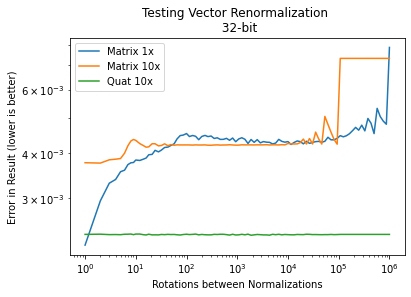

In [77]:
xvals = numRenorms
plt.plot(xvals, resTrads, label='Matrix 1x')
plt.plot(xvals, resTradCombos, label='Matrix 10x')
#plt.plot(xvals, resQuats, label='Quat 1x')
plt.plot(xvals, resQuatCombos, label='Quat 10x')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Rotations between Normalizations')
plt.ylabel('Error in Result (lower is better)')
plt.legend()
plt.title('Testing Vector Renormalization \n 32-bit')
plt.show()